In [3]:
# !conda install pytorch torchvision cuda90 -c pytorch -y
! pip install qn

  Running setup.py bdist_wheel for qn ... done
  Stored in directory: /home/ec2-user/.cache/pip/wheels/d5/23/f3/16ff9d2d70920f7e3e7c5dea03f9002e23827a415ae3a6429b
Successfully built qn
You are using pip version 9.0.1, however version 9.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:

%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [ ]:
import torch
from torch.autograd import Variable,grad
from torch import nn, optim
import torch.nn.functional as F
import qn
import numpy as np

import plot
from model import DisNet, GenNet
import sampler
from progress import Progress

def cuda(tensor):
    return tensor.cuda() if torch.cuda.is_available() else tensor

def cpu(tensor):
    return tensor.cpu() if torch.cuda.is_available() else tensor


prog = Progress()
config = qn.load('hyperparams.yml')
batchsize = config['batchsize']
dis_net = cuda(DisNet(config['dim_x']))
gen_net = cuda(GenNet(config['dim_z'],config['dim_x']))

dis_optim = optim.RMSprop(dis_net.parameters(), lr=config['dis_lr'],)
    # betas=(config['dis_beta1'],config['dis_beta2']))
gen_optim = optim.RMSprop(gen_net.parameters(), lr=config['gen_lr'],weight_decay=0.1)
    # betas=(config['gen_beta1'],config['gen_beta2']))


500 45.743807554244995


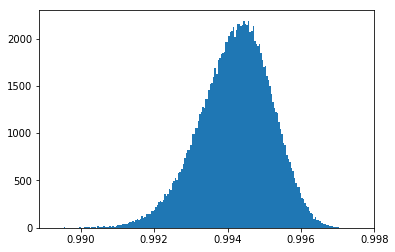

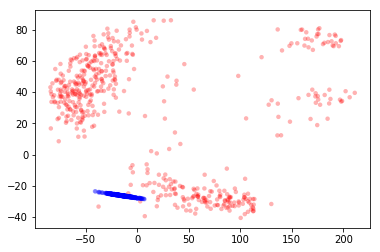

1000 45.981964111328125


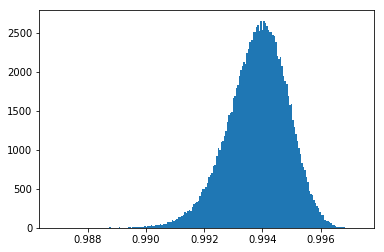

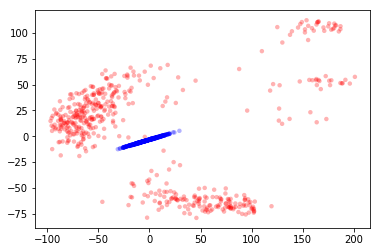

1500 45.71813988685608


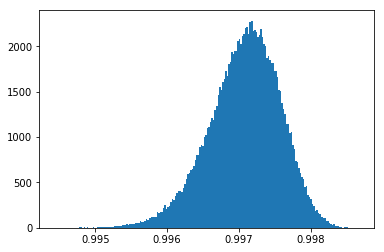

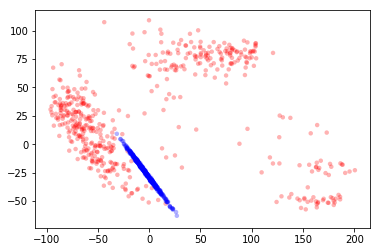

2000 45.66218852996826


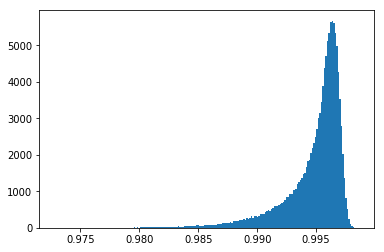

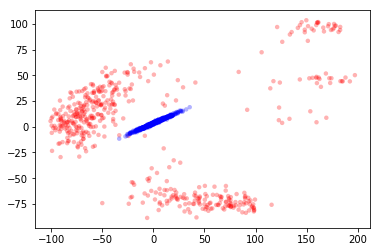

2500 45.884602308273315


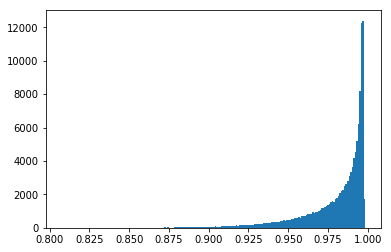

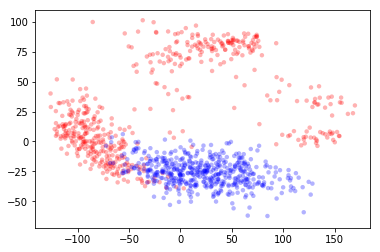

3000 45.77543234825134


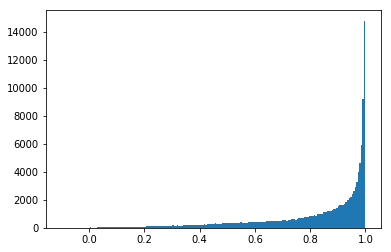

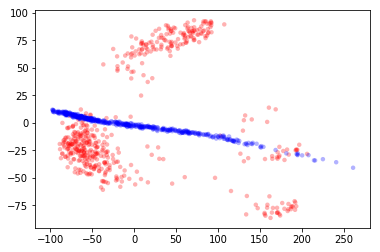

3500 45.75874209403992


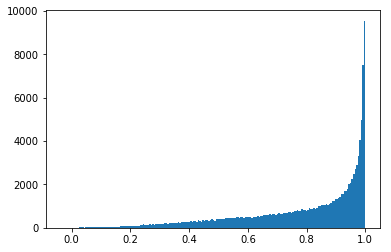

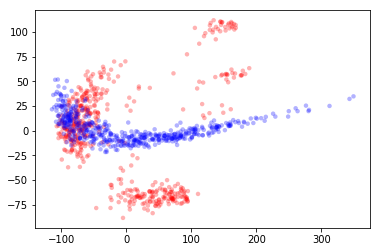

4000 45.95518398284912


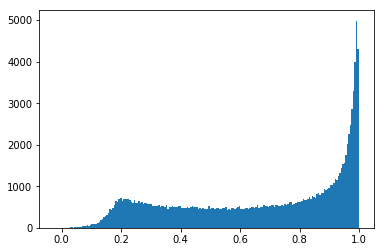

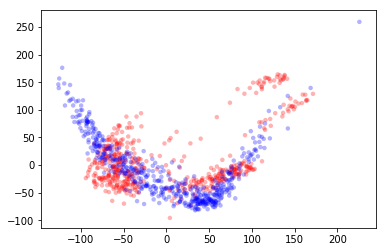

4500 46.088215827941895


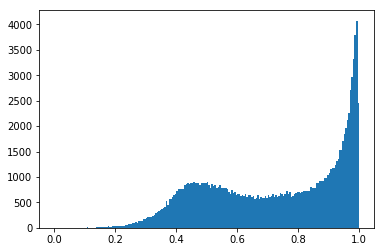

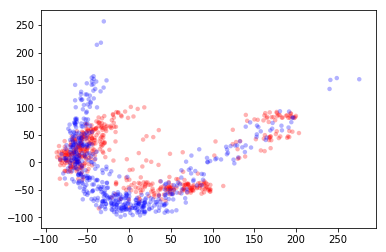

5000 45.937668800354004


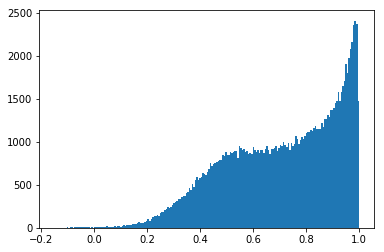

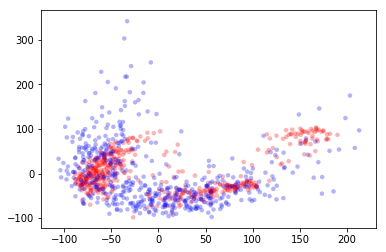

5500 45.68253183364868


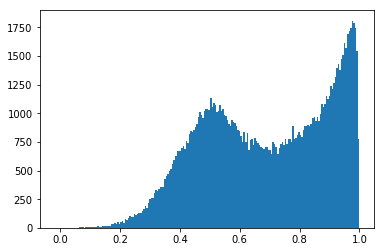

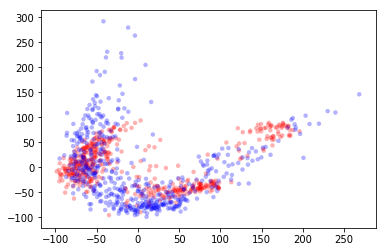

6000 45.73630738258362


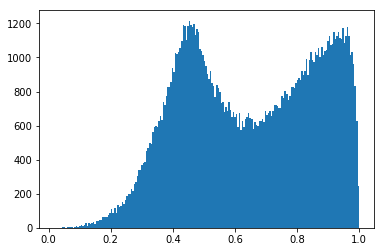

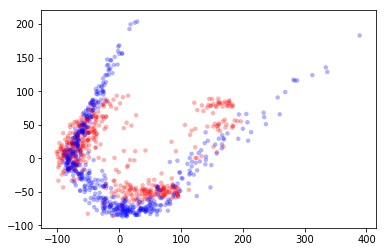

6500 45.95811080932617


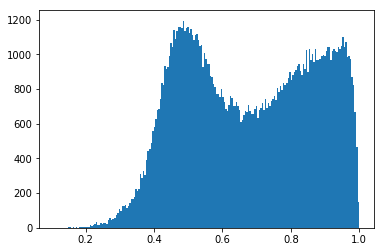

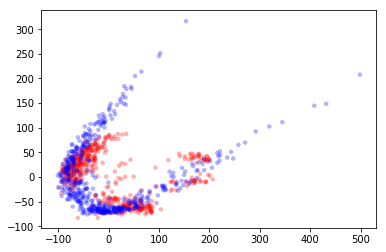

7000 45.752419233322144


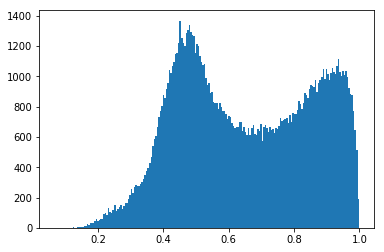

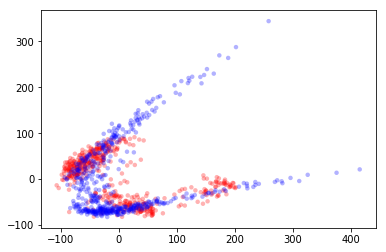

7500 45.91224551200867


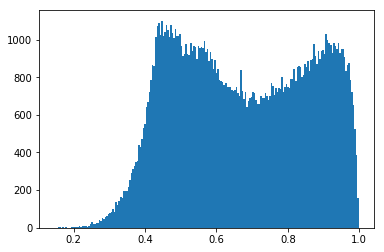

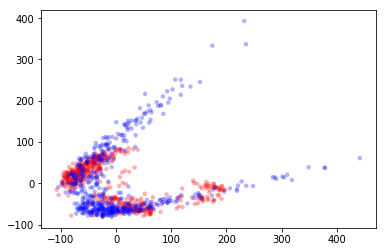

8000 45.963463306427


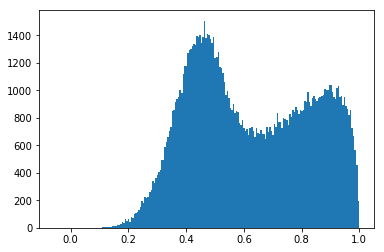

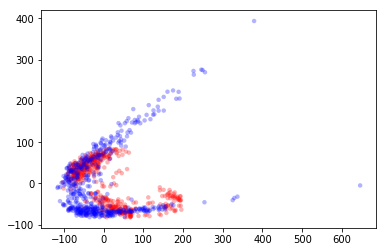

8500 45.93769884109497


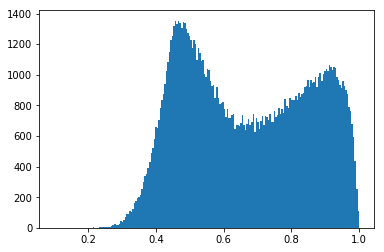

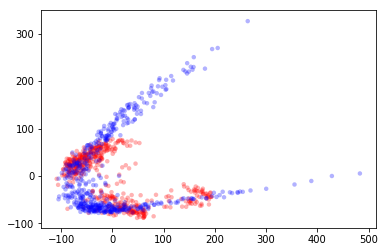

9000 46.10274529457092


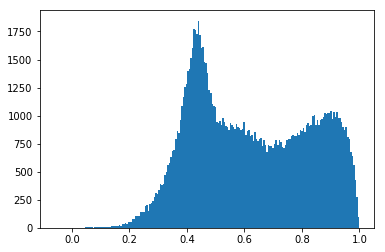

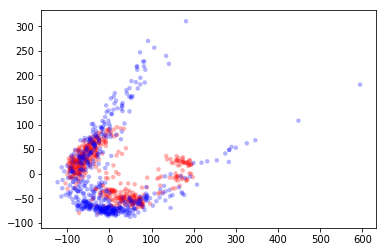

9500 45.85725688934326


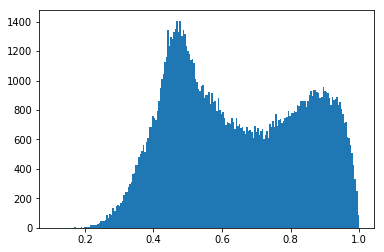

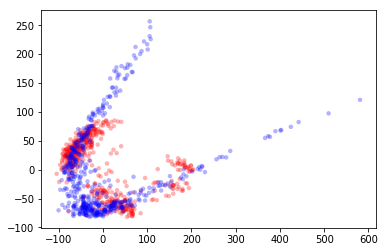

10000 45.862879514694214


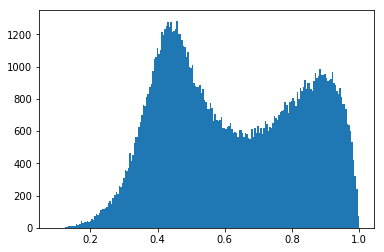

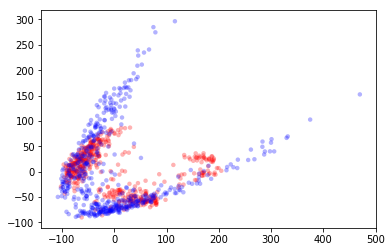

10500 46.05289649963379


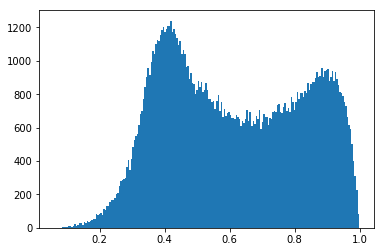

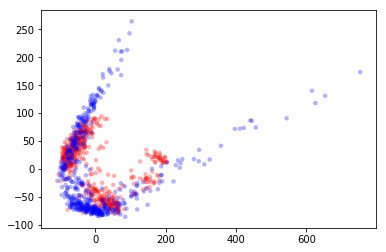

11000 45.751397371292114


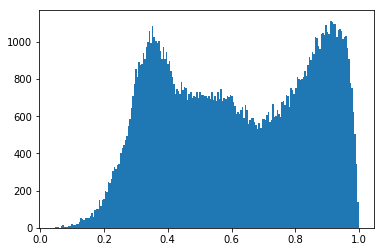

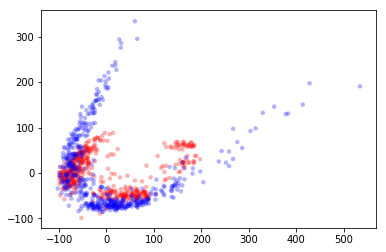

11500 45.64460039138794


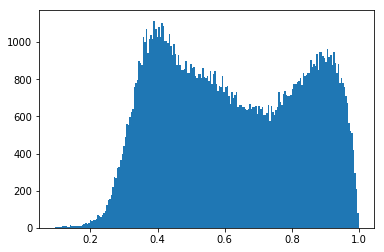

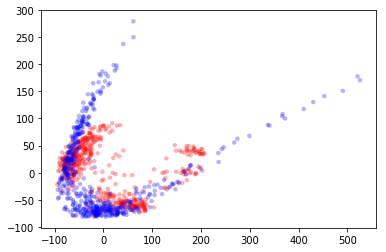

12000 45.90476179122925


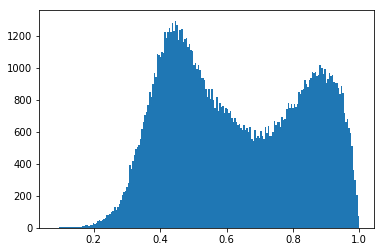

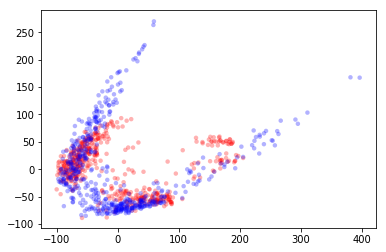

12500 45.9635853767395


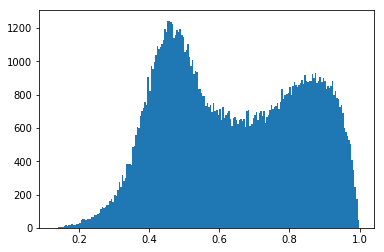

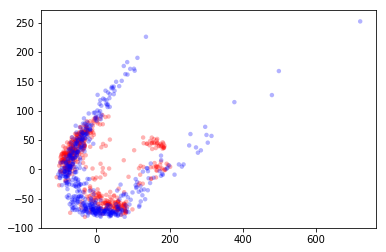

13000 45.765443563461304


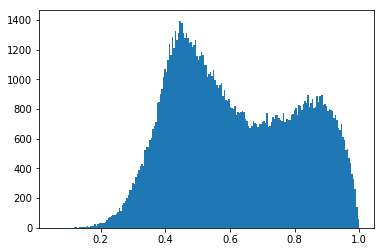

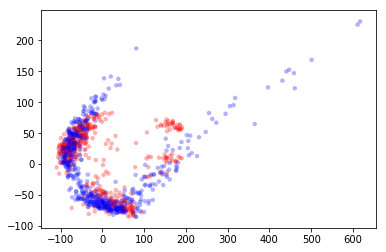

13500 45.89608287811279


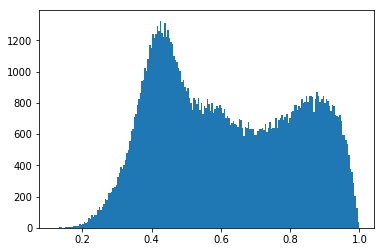

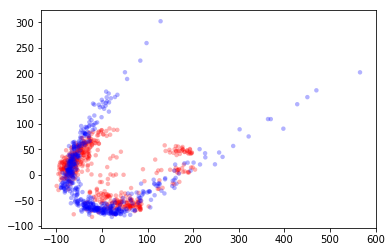

14000 45.94904017448425


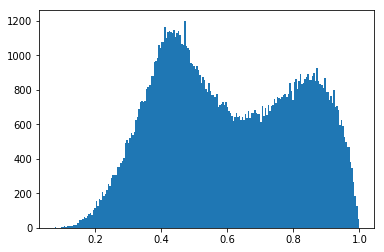

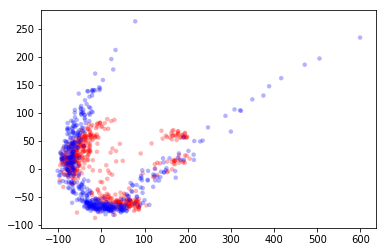

14500 45.852750062942505


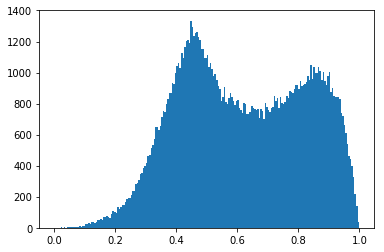

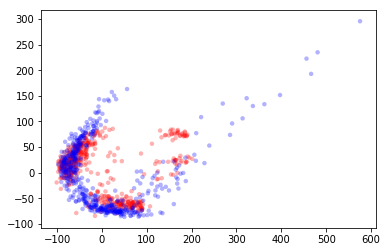

15000 45.77067708969116


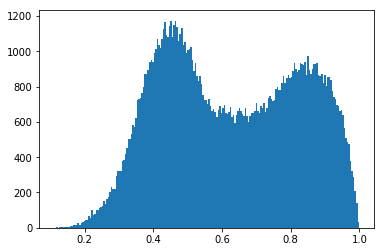

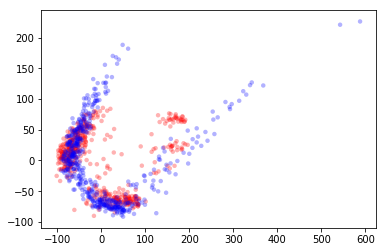

15500 45.86926817893982


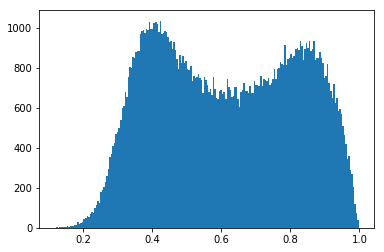

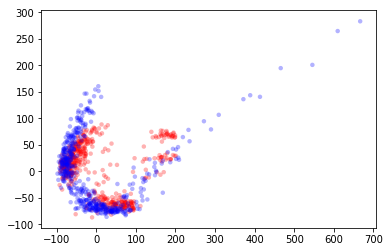

16000 46.09344530105591


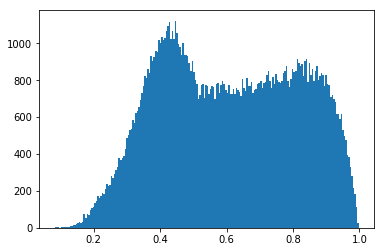

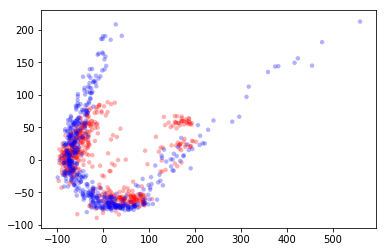

16500 45.807186126708984


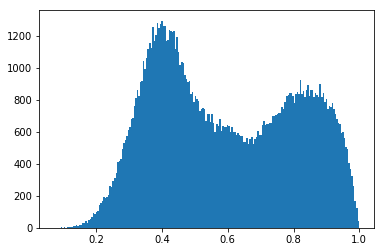

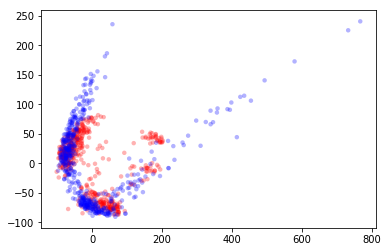

17000 45.95265483856201


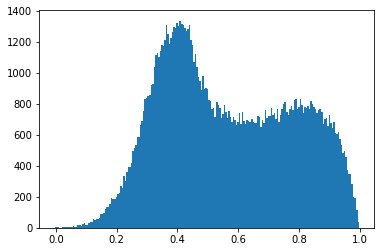

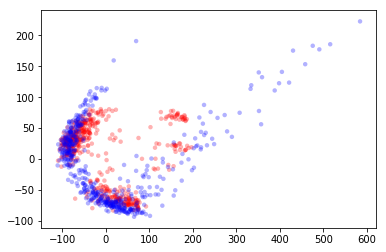

17500 45.91362929344177


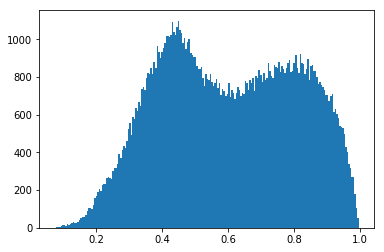

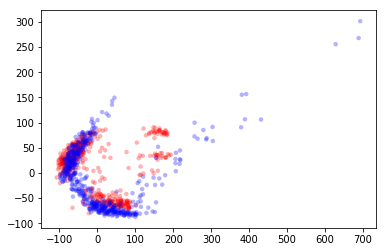

18000 45.9870069026947


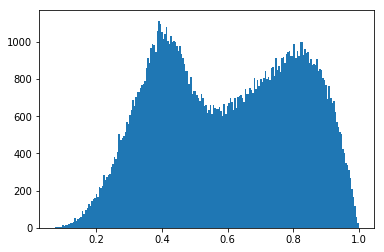

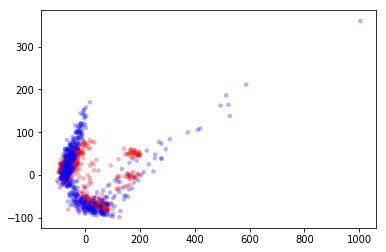

18500 46.1583936214447


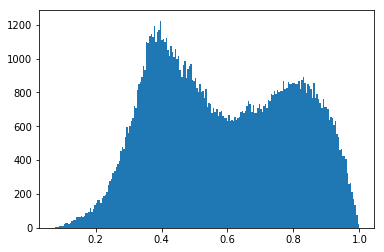

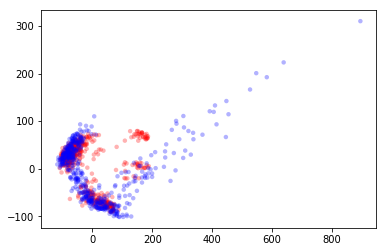

19000 45.70212197303772


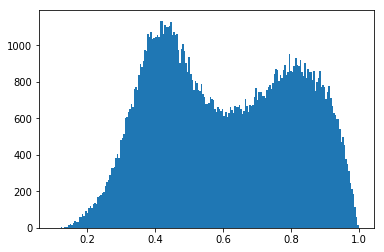

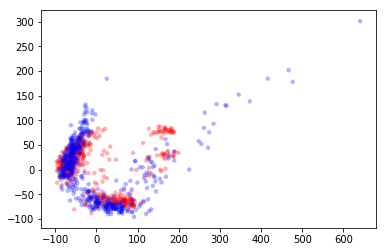

In [ ]:
prog.start()
for i in range(config['num_updates']):
    for _ in range(config['num_critic']):
        samples_true_numpy = sampler.sample_x(batchsize)
        samples_true = Variable(cuda(torch.from_numpy(samples_true_numpy)))
        z = sampler.sample_z(batchsize,config['dim_z'])
        z = Variable(cuda(torch.from_numpy(z)))
        samples_fake = gen_net(z).detach()
        samples_fake_numpy = cpu(samples_fake.data).numpy()      

        eps = np.random.uniform(size=batchsize).astype('float32')
        eps2 = 1 - eps
        # use transpose to broadcast
        samples_mid_numpy = (samples_true_numpy.T*eps).T + \
            (samples_fake_numpy.T*eps2).T
        samples_mid = Variable(cuda(torch.from_numpy(
            samples_mid_numpy)),requires_grad=True)
        f_mid = dis_net(samples_mid)
        # [0]:outputs tuple
        # torch.ones(): grad can be implicitly created only for scalar outputs
        grad_mid = grad(f_mid,samples_mid,cuda(torch.ones(f_mid.size())),
            create_graph=True)[0]
        grad_mid_norm = grad_mid.norm(dim=1)
        diff = (grad_mid_norm - 1).pow(2)

        f_true = dis_net(samples_true)
        f_fake = dis_net(samples_fake)
        loss_critic = f_fake.mean() - f_true.mean() + \
            (config['lda']*diff).mean()
        prog.add_loss_critic(cpu(loss_critic.data).numpy()[0])

        dis_optim.zero_grad()
        loss_critic.backward()
        dis_optim.step()

    prog.add_loss_dis()
    z = sampler.sample_z(batchsize,config['dim_z'])
    z = Variable(cuda(torch.from_numpy(z)))
    samples_fake = gen_net(z)
    f_fake = dis_net(samples_fake)
    loss_gen = -f_fake.mean()
    prog.add_loss_gen(cpu(loss_gen.data).numpy()[0])

    gen_optim.zero_grad()
    loss_gen.backward()
    gen_optim.step()

    if (i+1)%config['num_plot'] == 0:
        print(i+1,prog.duration())
        z = sampler.sample_z(500,config['dim_z'])
        z = Variable(cuda(torch.from_numpy(z)))
        samples_fake = cpu(gen_net(z).data).numpy()
        plot.plot_corr(samples_fake, filename='{}_corr'.format(i+1),show=True)
        plot.plot_scatter(sampler.mat[:,:500].T,samples_fake[:500,:],
            filename='{}_scatter'.format(i+1),show=True)
        prog.start()
prog.plot()


In [1]:
import torch


ModuleNotFoundError: No module named 'torch'